In [2]:
using Flux
using Flux: onehot, onecold, logitcrossentropy #, throttle, @epochs
using MLDatasets
using Random
using JLD2
using Statistics
using MLJBase
using Plots
using Zygote
using Distributions

In [3]:
train_data = JLD2.load_object("data/train_data.jld2");
test_data = JLD2.load_object("data/test_data.jld2");
x_train = JLD2.load_object("data/x_train.jld2");
y_train = JLD2.load_object("data/y_train.jld2");
x_test  = JLD2.load_object("data/x_test.jld2");
y_test  = JLD2.load_object("data/y_test.jld2");

In [3]:
accuracy(model,x,y) = sum(onecold(model(x)) .== onecold(y))/size(x,2)
accuracy(xy, model) = mean( onecold(model(x)) .== onecold(y) for (x,y) in xy)
loss(model) = (x,y)->logitcrossentropy(model(x), y)
loss(model,x,y) = loss(model)(x, y)
loss(xy, model) = loss(model)(hcat(map(first,xy)...), hcat(map(last,xy)...))

loss (generic function with 3 methods)

In [4]:
function make_nn(length_in = 19, length_out = 2, nodes = 2*19, hid_lay = 3, act_fun = sigmoid)
	first_layer = Dense(length_in, nodes, act_fun)
    intermediate_layers = [Dense(nodes,nodes,act_fun) for _ in 1:hid_lay-1]
    last_layer = Dense(nodes, length_out)

	return Chain(
        first_layer,
        intermediate_layers...,
        last_layer
    )
end
#https://discourse.julialang.org/t/function-for-creating-a-neural-network-with-n-hidden-layers-in-flux/75589

make_nn (generic function with 6 methods)

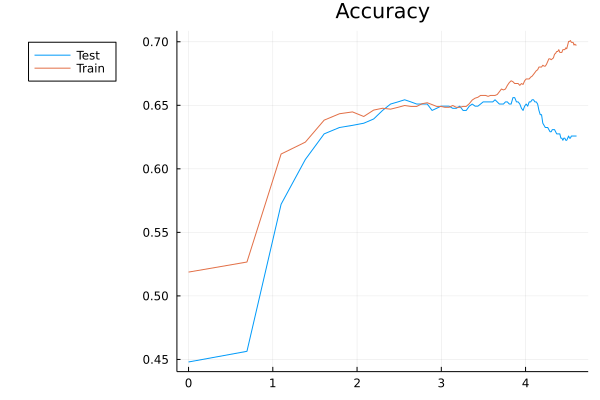

In [5]:
epochs = 100 # the number of epochs
# change population_size will increase training time, but may increase the accuracy
save_resultTest1 = zeros(epochs);
save_resultTrain1 = zeros(epochs);
# l1 = Dense(19, 2*19, sigmoid)
# l2 = Dense(2*19, 2)
model = make_nn()


for j in 1:epochs
    Flux.train!(loss(model), Flux.params(model), train_data, ADAM(1e-4))
    save_resultTest1[j] = save_resultTest1[j] + accuracy(test_data, model)
    save_resultTrain1[j] = save_resultTrain1[j] + accuracy(train_data, model)
end

plot(log.(1:epochs), save_resultTest1,label="Test")
plot!(log.(1:epochs), save_resultTrain1,label = "Train", title = "Accuracy", legend = :outertopleft)

In [6]:
epochs = 20
N = 50
w0 = 0.8
c1 = 1.6
c2 = 1.8

rng =Random.default_rng()

TaskLocalRNG()

In [7]:
# change population_size will increase training time, but may increase the accuracy
save_resultTest = zeros(epochs);
save_resultTrain = zeros(epochs);
# l1 = Dense(19, 2*19, sigmoid)
# l2 = Dense(2*19, 2)
for k in 1:10
    model = make_nn()
    θ, re = Flux.destructure(model)
    weights = [Vector{Float64}(undef,size(θ)[1]) for _ in 1:N];
    vec = [Vector{Float64}(undef,size(θ)[1]) for _ in 1:N];

    for i in 1:N
        vec[i] = rand(size(θ)[1])
        for j in 1:size(θ)[1]
            weights[i][j] = rand(Normal(θ[i], 0.05))
        end

    end
    p_best = copy(weights);
    g_best = sort(weights, lt=(x,y)->isless(loss(train_data, re(x)), loss(train_data, re(y))))[1];

    for i in 1:epochs
        for j in 1:N
            vec[j] = w0 *vec[j] + c1 *(1.0 - rand()) * (p_best[j] - vec[j]) + c2 * (1.0 - rand()) * (g_best - vec[j])
            weights[j] = vec[j]+weights[j]
            if loss(train_data, re(weights[j])) < loss(train_data, re(p_best[j]))
                p_best[j] = weights[j]
            end
        end
        g_best = sort(p_best, lt=(x,y)->isless(loss(train_data, re(x)), loss(train_data, re(y))))[1];

        save_resultTest[i] = save_resultTest[i] + accuracy(test_data, re(g_best))
        save_resultTrain[i] = save_resultTrain[i] + accuracy(train_data, re(g_best))
        if i%(epochs/5) == 0
            @info "MLP"  loss=loss(train_data, re(g_best)) accuracy = accuracy(train_data, re(g_best))
        end
        

    end
    

end

┌ Info: MLP
│   loss = 0.6881227088928694
│   accuracy = 0.5187319884726225
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.6816819797754392
│   accuracy = 0.5684438040345822
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.6816819797754392
│   accuracy = 0.5684438040345822
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.6816819797754392
│   accuracy = 0.5684438040345822
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.6816819797754392
│   accuracy = 0.5684438040345822
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.6924247504796389
│   accuracy = 0.5187319884726225
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.691982429064698
│   accuracy = 0.5655619596541787
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.691982429064698
│   accuracy = 0.5655619596541787
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.691982429064698
│   accuracy = 0.5655619596541787
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.691982429064698
│   accuracy = 0.5655619596541787
└ @ Main In[7]:35
┌ Info: MLP
│   loss = 0.6924452477015194
│   accuracy = 0.51873

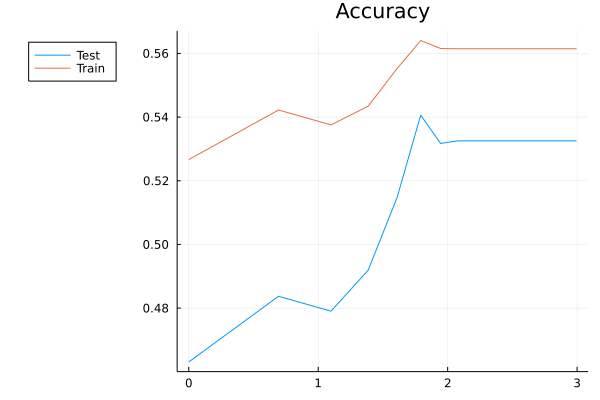

In [8]:
save_resultTest = save_resultTest ./ 10;
save_resultTrain = save_resultTrain ./ 10;

plot(log.(1:epochs), save_resultTest,label="Test")
plot!(log.(1:epochs), save_resultTrain,label = "Train", title = "Accuracy", legend = :outertopleft)

In [6]:
simplified_x_train_result = []
for i  = 1:size(x_train,2)
    if softmax(model(x_train[:,i]))[1]>0.5
        push!(simplified_x_train_result, 0)
    else
        push!(simplified_x_train_result, 1)
    end
end
simplified_y_train = []
for i  = 1:size(x_train,2)
    if y_train[i] == 0
        push!(simplified_y_train, 0)
    else
        push!(simplified_y_train, 1)
    end
end

# ConfusionMatrix for the training data
print("ConfusionMatrix for the training data\n")
ConfusionMatrix()(simplified_x_train_result, simplified_y_train)

ConfusionMatrix for the training data


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │     253     │     470     │
├─────────────┼─────────────┼─────────────┤
│      1      │     415     │     250     │
└─────────────┴─────────────┴─────────────┘


In [7]:
simplified_x_test_result = []
for i  = 1:size(x_test,2) 
    if softmax(model(x_test[:,i]))[1]>0.5
        push!(simplified_x_test_result, 0)
    else
        push!(simplified_x_test_result, 1)
    end
end
simplified_y_test = []
for i  = 1:size(x_test,2) 
    if y_test[i] == 0
        push!(simplified_y_test, 0)
    else
        push!(simplified_y_test, 1)
    end
end

# ConfusionMatrix for the test data
print("ConfusionMatrix for the test data\n")
ConfusionMatrix()(simplified_x_test_result, simplified_y_test)

ConfusionMatrix for the test data


┌ Warning: The classes are un-ordered,
│ using: negative='0' and positive='1'.
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\xkzmx\.julia\packages\MLJBase\pCiRR\src\measures\confusion_matrix.jl:112


              ┌───────────────────────────┐
              │       Ground Truth        │
┌─────────────┼─────────────┬─────────────┤
│  Predicted  │      0      │      1      │
├─────────────┼─────────────┼─────────────┤
│      0      │     115     │     173     │
├─────────────┼─────────────┼─────────────┤
│      1      │     214     │     94      │
└─────────────┴─────────────┴─────────────┘
